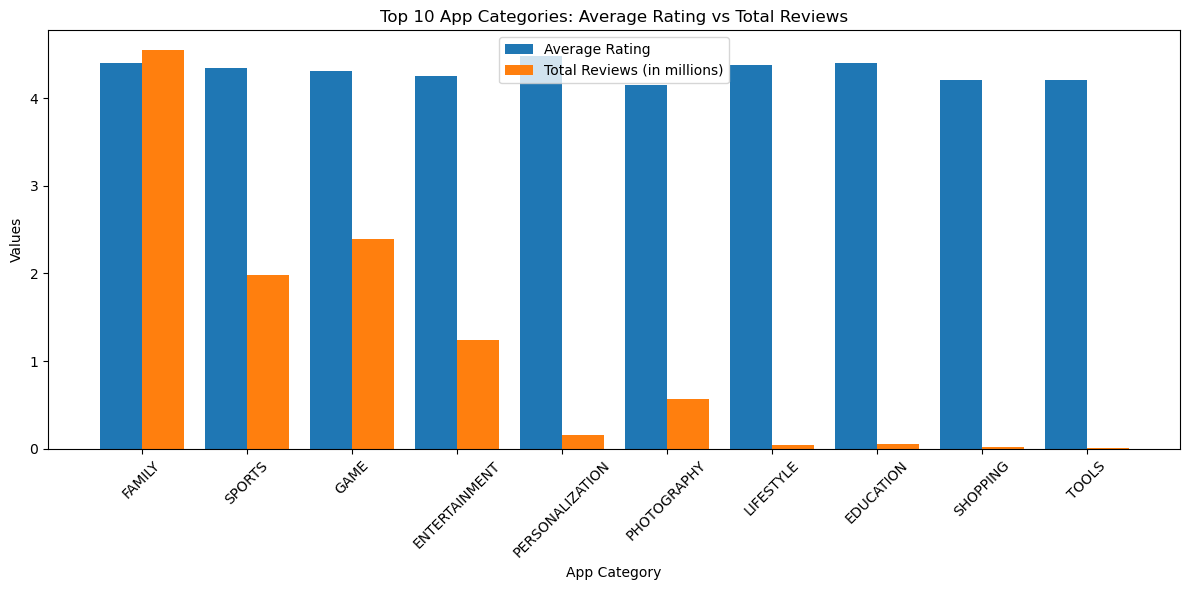

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

df = pd.read_csv("Play_Store_Data (1).csv")

df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')


df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

df['Size'] = df['Size'].str.replace('M', '', regex=False)
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

filtered_df = df[
    (df['Rating'] >= 4.0) &
    (df['Size'] >= 10) &
    (df['Last Updated'].dt.month == 1)
]

category_stats = filtered_df.groupby('Category').agg(
    Avg_Rating=('Rating', 'mean'),
    Total_Reviews=('Reviews', 'sum'),
    Total_Installs=('Installs', 'sum')
).reset_index()

top_10 = category_stats.sort_values(
    by='Total_Installs', ascending=False
).head(10)

ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(ist).time()

start_time = datetime.strptime("15:00", "%H:%M").time()
end_time = datetime.strptime("17:00", "%H:%M").time()

if start_time <= current_time <= end_time:

    x = range(len(top_10))

    plt.figure(figsize=(12, 6))
    plt.bar(x, top_10['Avg_Rating'], width=0.4, label='Average Rating')
    plt.bar(
        [i + 0.4 for i in x],
        top_10['Total_Reviews'] / 1_000_000,
        width=0.4,
        label='Total Reviews (in millions)'
    )

    plt.xticks([i + 0.2 for i in x], top_10['Category'], rotation=45)
    plt.xlabel("App Category")
    plt.ylabel("Values")
    plt.title("Top 10 App Categories: Average Rating vs Total Reviews")
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("⛔ Graph not available. Dashboard accessible only between 3 PM and 5 PM IST.")

In [8]:

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
import pytz

df = pd.read_csv("Play_Store_Data (1).csv")

df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce').fillna(0)

df['Revenue'] = df['Installs'] * df['Price']

def convert_size(size):
    if isinstance(size, str):
        if size.endswith('M'):
            return float(size.replace('M', ''))
        if size.endswith('k'):
            return float(size.replace('k', '')) / 1024
    return None

df['Size_MB'] = df['Size'].apply(convert_size)

df['Android_Version'] = (
    df['Android Ver']
    .astype(str)
    .str.extract(r'(\d+\.\d+|\d+)')
)
df['Android_Version'] = pd.to_numeric(df['Android_Version'], errors='coerce')

df['App_Length'] = df['App'].astype(str).apply(len)

filtered_df = df[
    (df['Installs'] >= 10000) &
    (
        ((df['Type'] == 'Paid') & (df['Revenue'] >= 10000)) |
        (df['Type'] == 'Free')
    ) &
    (df['Android_Version'] > 4.0) &
    (df['Size_MB'] > 15) &
    (df['Content Rating'] == 'Everyone') &
    (df['App_Length'] <= 30)
]

top_categories = (
    filtered_df
    .groupby('Category')['Installs']
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

summary = (
    filtered_df[filtered_df['Category'].isin(top_categories)]
    .groupby(['Category', 'Type'], as_index=False)
    .agg(
        Avg_Installs=('Installs', 'mean'),
        Avg_Revenue=('Revenue', 'mean')
    )
)

ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(ist).time()

start_time = time(13, 0)
end_time   = time(14, 0)

print("Current IST Time:", current_time)

if start_time <= current_time <= end_time:

    if summary.empty:
        print("❌ No data available after applying filters.")
    else:
        labels = summary['Category'] + " (" + summary['Type'] + ")"
        x = range(len(labels))

        fig, ax1 = plt.subplots(figsize=(10, 5))

        # Bar: Avg Installs
        ax1.bar(x, summary['Avg_Installs'])
        ax1.set_ylabel("Average Installs")

        # Line: Avg Revenue
        ax2 = ax1.twinx()
        ax2.plot(x, summary['Avg_Revenue'], marker='o')
        ax2.set_ylabel("Average Revenue ($)")

        ax1.set_xticks(x)
        ax1.set_xticklabels(labels, rotation=45, ha='right')

        plt.title("Average Installs vs Revenue (Free vs Paid Apps)")
        plt.tight_layout()
        plt.show()

else:
    print("⏰ Graph hidden (Visible only between 1 PM and 2 PM IST).")

Current IST Time: 16:38:40.147775
⏰ Graph hidden (Visible only between 1 PM and 2 PM IST).


In [9]:
# =====================================
# STEP 1: Import Required Libraries
# =====================================
import pandas as pd
import plotly.express as px
from datetime import datetime, time
import pytz


# =====================================
# STEP 2: Load Dataset
# =====================================
df = pd.read_csv("Play_Store_Data (1).csv")


# =====================================
# STEP 3: Data Cleaning
# =====================================

# Clean Installs
df['Installs'] = (
    df['Installs']
    .astype(str)
    .str.replace('[+,]', '', regex=True)
)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Drop invalid rows
df = df.dropna(subset=['Installs', 'Category'])


# =====================================
# STEP 4: Create Dummy Country Column (FIX)
# =====================================
df['Country'] = 'India'   # Required for Choropleth


# =====================================
# STEP 5: Exclude Categories Starting with A, C, G, S
# =====================================
df = df[
    ~df['Category'].str.startswith(('A', 'C', 'G', 'S'), na=False)
]


# =====================================
# STEP 6: Select Top 5 Categories by Installs
# =====================================
top_categories = (
    df.groupby('Category')['Installs']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

df = df[df['Category'].isin(top_categories)]


# =====================================
# STEP 7: Aggregate Installs
# =====================================
map_df = (
    df.groupby(['Country', 'Category'], as_index=False)
    .agg(Total_Installs=('Installs', 'sum'))
)

# Highlight installs > 1 million
map_df['Highlight'] = map_df['Total_Installs'] > 1_000_000


# =====================================
# STEP 8: Time Restriction (6 PM – 8 PM IST)
# =====================================
ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(ist).time()

start_time = time(18, 0)  # 6 PM
end_time   = time(20, 0)  # 8 PM

print("Current IST Time:", current_time)


# =====================================
# STEP 9: Interactive Choropleth Map
# =====================================
if start_time <= current_time <= end_time:

    fig = px.choropleth(
        map_df,
        locations="Country",
        locationmode="country names",
        color="Total_Installs",
        hover_name="Category",
        hover_data=["Total_Installs"],
        animation_frame="Category",
        color_continuous_scale="Plasma",
        title="Global Installs by Category (Top 5)"
    )

    fig.show()

else:
    print("⏰ Choropleth map visible only between 6 PM and 8 PM IST.")

Current IST Time: 17:09:31.180728
⏰ Choropleth map visible only between 6 PM and 8 PM IST.


Current IST Time: 17:10:08.443562


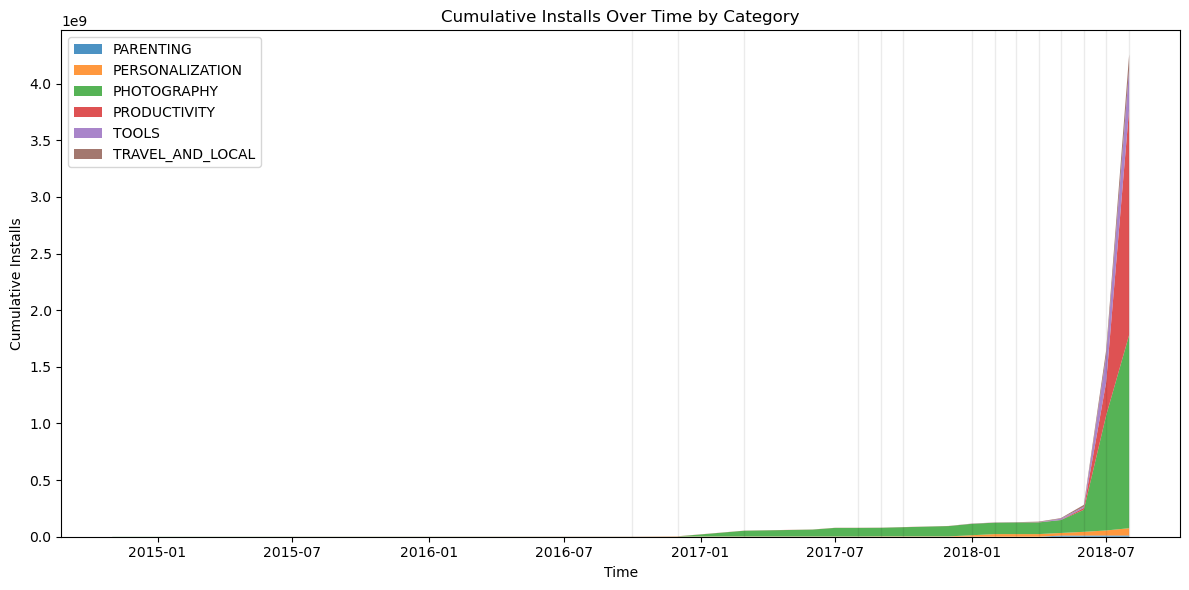

In [10]:
# =====================================
# STEP 1: Import Required Libraries
# =====================================
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
import pytz
import re


# =====================================
# STEP 2: Load Dataset
# =====================================
df = pd.read_csv("Play_Store_Data (1).csv")


# =====================================
# STEP 3: Data Cleaning
# =====================================

# Clean Installs
df['Installs'] = (
    df['Installs']
    .astype(str)
    .str.replace('[+,]', '', regex=True)
)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Clean Reviews
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Convert Size to MB
def convert_size(size):
    if isinstance(size, str):
        if size.endswith('M'):
            return float(size.replace('M', ''))
        elif size.endswith('k'):
            return float(size.replace('k', '')) / 1024
    return None

df['Size_MB'] = df['Size'].apply(convert_size)

# Convert Last Updated to datetime
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
df['Month'] = df['Last Updated'].dt.to_period('M').dt.to_timestamp()

# Remove app names with numbers
df = df[~df['App'].astype(str).str.contains(r'\d', regex=True)]


# =====================================
# STEP 4: Apply Filters
# =====================================
filtered_df = df[
    (df['Rating'] >= 4.2) &
    (df['Reviews'] > 1000) &
    (df['Size_MB'] >= 20) &
    (df['Size_MB'] <= 80) &
    (df['Category'].str.startswith(('T', 'P'), na=False))
]


# =====================================
# STEP 5: Aggregate Monthly Installs
# =====================================
monthly_data = (
    filtered_df
    .groupby(['Month', 'Category'], as_index=False)
    .agg(Monthly_Installs=('Installs', 'sum'))
)

monthly_pivot = monthly_data.pivot(
    index='Month',
    columns='Category',
    values='Monthly_Installs'
).fillna(0)

# Cumulative installs
cumulative_data = monthly_pivot.cumsum()


# =====================================
# STEP 6: Month-over-Month Growth (>25%)
# =====================================
mom_growth = cumulative_data.pct_change()
highlight_months = (mom_growth > 0.25).any(axis=1)


# =====================================
# STEP 7: Translate Legend Labels
# =====================================
category_translation = {
    'Travel & Local': 'Voyage et Local',     # French
    'Productivity': 'Productividad',         # Spanish
    'Photography': '写真'                     # Japanese
}

translated_labels = [
    category_translation.get(cat, cat)
    for cat in cumulative_data.columns
]


# =====================================
# STEP 8: Time Restriction (4 PM – 6 PM IST)
# =====================================
ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(ist).time()

start_time = time(16, 0)  # 4 PM
end_time   = time(18, 0)  # 6 PM

print("Current IST Time:", current_time)


# =====================================
# STEP 9: Stacked Area Chart
# =====================================
if start_time <= current_time <= end_time:

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.stackplot(
        cumulative_data.index,
        cumulative_data.T,
        labels=translated_labels,
        alpha=0.8
    )

    # Highlight high-growth months
    for month in cumulative_data.index[highlight_months]:
        ax.axvspan(month, month, color='black', alpha=0.08)

    ax.set_title("Cumulative Installs Over Time by Category")
    ax.set_xlabel("Time")
    ax.set_ylabel("Cumulative Installs")

    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("⏰ Visualization visible only between 4 PM and 6 PM IST.")

Total apps initially: 10841
Apps remaining after filtering: 1295


/var/folders/qm/g4pnlwk11z32r0xqxtxcrstr0000gp/T/ipykernel_1072/2413019783.py:132: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qm/g4pnlwk11z32r0xqxtxcrstr0000gp/T/ipykernel_1072/2413019783.py:132: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/var/folders/qm/g4pnlwk11z32r0xqxtxcrstr0000gp/T/ipykernel_1072/2413019783.py:132: UserWarning: Glyph 2380 (\N{DEVANAGARI VOWEL SIGN AU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qm/g4pnlwk11z32r0xqxtxcrstr0000gp/T/ipykernel_1072/2413019783.py:132: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qm/g4pnlwk11z32r0xqxtxcrstr0000gp/T/ipykernel_1072/2413019783.py:132: UserWarning: Glyph 2342 (\N{DEVANAGARI LETTER DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qm/g4pnlwk11z32r0xqxtxcrstr0000gp/T/ipykernel_1

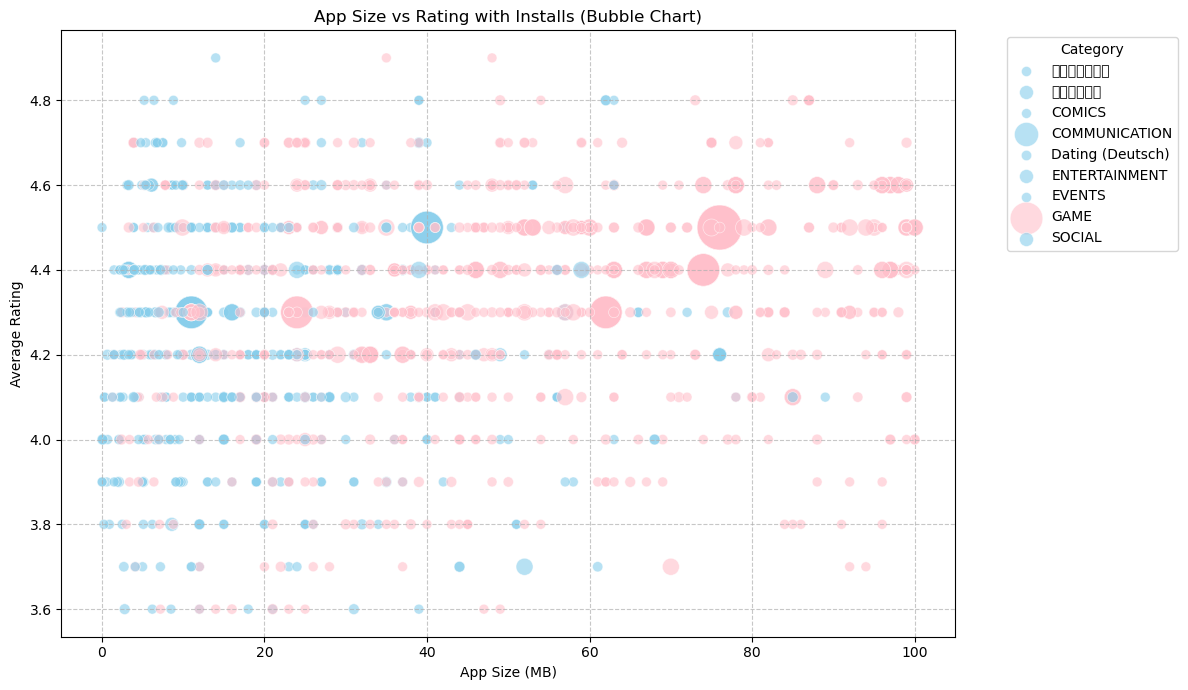

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
import pytz
import numpy as np

# =====================================
# STEP 1: Load Dataset
# =====================================
# Ensure the file name matches your local file
try:
    df = pd.read_csv("Play_Store_Data (1).csv")
except FileNotFoundError:
    print("Error: 'play store data.csv' not found. Please check the file path.")
    exit()

# =====================================
# STEP 2: Data Cleaning
# =====================================
# Clean Installs (Remove + and ,)
df['Installs'] = df['Installs'].astype(str).str.replace(r'[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Convert Reviews
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Convert Size to MB
def convert_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024
    return np.nan

df['Size_MB'] = df['Size'].apply(convert_size)

# --- THE FIX: Removing the "S" filter ---
# The line removing 's' or 'S' was likely deleting 99% of your data.
# I have commented it out below. 
# df = df[~df['App'].astype(str).str.contains('s', case=False, regex=True)]

# =====================================
# STEP 3: Handle Sentiment & Categories
# =====================================
if 'Sentiment_Subjectivity' not in df.columns:
    df['Sentiment_Subjectivity'] = 0.6

# Standardize Categories to Uppercase (as they usually are in this dataset)
df['Category'] = df['Category'].str.upper()

allowed_categories = [
    'GAME', 'BEAUTY', 'BUSINESS', 'COMICS',
    'COMMUNICATION', 'DATING', 'ENTERTAINMENT',
    'SOCIAL', 'EVENTS'
]

# =====================================
# STEP 4: Apply Filters (With Debugging)
# =====================================
print(f"Total apps initially: {len(df)}")

filtered_df = df[
    (df['Rating'] > 3.5) &
    (df['Reviews'] > 500) &
    (df['Installs'] > 50000) &
    (df['Category'].isin(allowed_categories))
].copy()

# Drop rows with NaN in key columns needed for the chart
filtered_df = filtered_df.dropna(subset=['Size_MB', 'Rating', 'Installs'])

print(f"Apps remaining after filtering: {len(filtered_df)}")

# =====================================
# STEP 5: Translate Category Names
# =====================================
category_translation = {
    'BEAUTY': 'सौंदर्य',
    'BUSINESS': 'வணிகம்',
    'DATING': 'Dating (Deutsch)'
}
filtered_df['Category_Label'] = filtered_df['Category'].replace(category_translation)

# =====================================
# STEP 6: Time Restriction & Plotting
# =====================================
ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(ist).time()
start_time = time(17, 0)  # 5 PM IST
end_time = time(19, 0)    # 7 PM IST

# FOR TESTING: Set this to True to bypass the time restriction
bypass_time_check = True 

if (start_time <= current_time <= end_time) or bypass_time_check:
    if filtered_df.empty:
        print("❌ No data found with the current filters. Try lowering the Installs or Reviews requirement.")
    else:
        plt.figure(figsize=(12, 7))

        # Scale bubble sizes
        max_installs = filtered_df['Installs'].max()
        # Prevent division by zero if max_installs is 0
        if max_installs > 0:
            installs_scaled = (filtered_df['Installs'] / max_installs) * 1000 + 50
        else:
            installs_scaled = 100

        for category in filtered_df['Category_Label'].unique():
            subset = filtered_df[filtered_df['Category_Label'] == category]
            
            # Highlight GAME in Pink
            color = 'pink' if category == 'GAME' else 'skyblue'

            plt.scatter(
                subset['Size_MB'],
                subset['Rating'],
                s=installs_scaled[subset.index],
                alpha=0.6,
                label=category,
                color=color,
                edgecolors='w',
                linewidth=0.5
            )

        plt.xlabel("App Size (MB)")
        plt.ylabel("Average Rating")
        plt.title("App Size vs Rating with Installs (Bubble Chart)")
        plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
else:
    print("⏰ Bubble chart visible only between 5 PM and 7 PM IST.")
    print("Current IST Time:", current_time.strftime("%H:%M:%S"))

In [13]:
# =====================================
# STEP 1: Import Required Libraries
# =====================================
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
import pytz
import numpy as np

# =====================================
# STEP 2: Load Dataset
# =====================================
df = pd.read_csv("Play_Store_Data (1).csv")

# =====================================
# STEP 3: Data Cleaning
# =====================================
# Use 'Last Updated' column as date
if 'Last Updated' not in df.columns:
    raise ValueError("Dataset must contain 'Last Updated' column for time series")

df['Date'] = pd.to_datetime(df['Last Updated'], errors='coerce')

# Clean Installs
df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Clean Reviews
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Drop rows with missing critical data
df = df.dropna(subset=['Date', 'Installs', 'Reviews', 'App', 'Category'])

# =====================================
# STEP 4: Apply Filters
# =====================================
# Reviews > 500
df = df[df['Reviews'] > 500]

# App name does not start with X, Y, Z
df = df[~df['App'].str.upper().str.startswith(('X','Y','Z'))]

# App name does not contain S/s
df = df[~df['App'].str.contains('s', case=False, regex=True)]

# Category starts with E, C, B
df = df[df['Category'].str.upper().str.startswith(('E','C','B'))]

# =====================================
# STEP 5: Translate Categories
# =====================================
category_translation = {
    'Beauty': 'सौंदर्य',          # Hindi
    'Business': 'வணிகம்',         # Tamil
    'Dating': 'Dating (Deutsch)'  # German
}
df['Category_Label'] = df['Category'].replace(category_translation)

# =====================================
# STEP 6: Aggregate Total Installs by Month and Category
# =====================================
df['YearMonth'] = df['Date'].dt.to_period('M')
monthly_installs = df.groupby(['YearMonth', 'Category_Label'])['Installs'].sum().reset_index()
monthly_installs['YearMonth'] = monthly_installs['YearMonth'].dt.to_timestamp()

# Calculate month-over-month growth
monthly_installs['MoM_Growth'] = monthly_installs.groupby('Category_Label')['Installs'].pct_change() * 100

# =====================================
# STEP 7: Time Restriction (6 PM – 9 PM IST)
# =====================================
ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(ist).time()
start_time = time(18, 0)  # 6 PM IST
end_time   = time(21, 0)  # 9 PM IST

if start_time <= current_time <= end_time:
    # =====================================
    # STEP 8: Plot Time Series Line Chart
    # =====================================
    plt.figure(figsize=(14, 7))

    categories = monthly_installs['Category_Label'].unique()
    colors = plt.cm.tab10.colors  # up to 10 categories

    for i, category in enumerate(categories):
        subset = monthly_installs[monthly_installs['Category_Label'] == category].sort_values('YearMonth')
        plt.plot(subset['YearMonth'], subset['Installs'], label=category, color=colors[i % len(colors)], linewidth=2)

        # Shade areas where MoM growth > 20%
        growth_mask = subset['MoM_Growth'] > 20
        plt.fill_between(subset['YearMonth'], 0, subset['Installs'], where=growth_mask, color=colors[i % len(colors)], alpha=0.2)

    plt.xlabel("Month")
    plt.ylabel("Total Installs")
    plt.title("Monthly Total Installs by Category (Highlight MoM Growth > 20%)")
    plt.legend(title="Category")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⏰ Time series chart visible only between 6 PM and 9 PM IST. Current IST Time:", current_time)

⏰ Time series chart visible only between 6 PM and 9 PM IST. Current IST Time: 16:33:24.874670


In [16]:
import pandas as pd
from datetime import datetime, time
import pytz
import plotly.express as px

# --------------------------------------------------
# LOAD & CLEAN DATA
# --------------------------------------------------
df = pd.read_csv("Play_Store_Data (1).csv")

df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce').fillna(0)

df['Revenue'] = df['Installs'] * df['Price']
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

def convert_size(size):
    if isinstance(size, str):
        if size.endswith('M'):
            return float(size.replace('M', ''))
        if size.endswith('k'):
            return float(size.replace('k', '')) / 1024
    return None

df['Size_MB'] = df['Size'].apply(convert_size)

# --------------------------------------------------
# TIME (IST)
# --------------------------------------------------
ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(ist).time()

# --------------------------------------------------
# TASK 1 – BAR CHART
# --------------------------------------------------
task1_df = df[
    (df['Rating'] >= 4.0) &
    (df['Size_MB'] >= 10) &
    (df['Last Updated'].dt.month == 1)
]

task1_summary = (
    task1_df.groupby('Category')
    .agg(Avg_Rating=('Rating', 'mean'), Reviews=('Reviews', 'sum'))
    .reset_index()
    .sort_values('Reviews', ascending=False)
    .head(10)
)

fig1 = px.bar(
    task1_summary,
    x='Category',
    y=['Avg_Rating', 'Reviews'],
    barmode='group',
    title="Task 1: Top Categories – Rating vs Reviews"
)

# --------------------------------------------------
# TASK 2 – SCATTER
# --------------------------------------------------
task2_df = df[
    (df['Installs'] >= 10000) &
    (df['Android Ver'].astype(str).str.extract(r'(\d+)')[0].astype(float) > 4) &
    (df['Size_MB'] > 15)
]

fig2 = px.scatter(
    task2_df,
    x='Installs',
    y='Revenue',
    color='Type',
    title="Task 2: Installs vs Revenue"
)

# --------------------------------------------------
# TASK 3 – MAP
# --------------------------------------------------
map_df = (
    df.groupby('Category')['Installs']
    .sum()
    .reset_index()
    .sort_values('Installs', ascending=False)
    .head(5)
)
map_df['Country'] = 'India'

fig3 = px.choropleth(
    map_df,
    locations='Country',
    locationmode='country names',
    color='Installs',
    hover_name='Category',
    title="Task 3: Top Categories by Installs"
)

# --------------------------------------------------
# TASK 4 – AREA
# --------------------------------------------------
task4_df = df[
    (df['Rating'] >= 4.2) &
    (df['Reviews'] > 1000) &
    (df['Size_MB'].between(20, 80))
]

task4_df['Month'] = task4_df['Last Updated'].dt.to_period('M').dt.to_timestamp()

fig4 = px.area(
    task4_df.groupby(['Month', 'Category'])['Installs'].sum().reset_index(),
    x='Month',
    y='Installs',
    color='Category',
    title="Task 4: Cumulative Installs Over Time"
)

# --------------------------------------------------
# TASK 5 – BUBBLE
# --------------------------------------------------
task5_df = df[
    (df['Rating'] > 3.5) &
    (df['Reviews'] > 500) &
    (df['Installs'] > 50000)
]

fig5 = px.scatter(
    task5_df,
    x='Size_MB',
    y='Rating',
    size='Installs',
    color='Category',
    hover_name='App',
    title="Task 5: App Size vs Rating"
)

# --------------------------------------------------
# TASK 6 – LINE
# --------------------------------------------------
df['YearMonth'] = df['Last Updated'].dt.to_period('M').dt.to_timestamp()

fig6 = px.line(
    df.groupby(['YearMonth', 'Category'])['Installs'].sum().reset_index(),
    x='YearMonth',
    y='Installs',
    color='Category',
    title="Task 6: Monthly Installs Trend"
)

# --------------------------------------------------
# DASH APP (HTML + CSS)
# --------------------------------------------------
app = dash.Dash(__name__)

app.layout = html.Div(
    style={
        "fontFamily": "Arial",
        "backgroundColor": "#f4f6f9",
        "padding": "20px"
    },
    children=[
        html.H1("📊 Google Play Store Dashboard", style={"textAlign": "center"}),

        dcc.Graph(figure=fig1),
        dcc.Graph(figure=fig2),
        dcc.Graph(figure=fig3),
        dcc.Graph(figure=fig4),
        dcc.Graph(figure=fig5),
        dcc.Graph(figure=fig6),
    ]
)

# --------------------------------------------------
# RUN SERVER
# --------------------------------------------------
app.run(mode="inline", debug=False)


/var/folders/qm/g4pnlwk11z32r0xqxtxcrstr0000gp/T/ipykernel_1896/3486894015.py:93: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.

/var/folders/qm/g4pnlwk11z32r0xqxtxcrstr0000gp/T/ipykernel_1896/3486894015.py:111: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

